# **Intelligent Recipe Recommendation Assistant**

This project implements an **agentic RAG** as an intelligent recipe recommendation assistant.
It allows users to **search and retrieve recipes** (including ingredients and preparation steps) and **suggest recipes** based on provided ingredients.
If a recipe is not found in the **All-Recipes dataset** (+2M recipes), the assistant performs a **Web search** to retrieve and present relevant results.



---



Install Required Dependencies

In [ ]:
!pip install --upgrade --quiet scikit-learn langchain langchain-community langchain-core langgraph datasets langchain_groq faiss-cpu

Import the required libraries

In [2]:
import json
import os
import numpy as np
import uuid
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
from datasets import load_dataset
import faiss
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from typing_extensions import List, TypedDict

In [3]:
os.environ["TAVILY_API_KEY"] = "xxx"
os.environ["GROQ_API_KEY"] = "xxx"

Load and process the recipe dataset **(Only 5% for testing)**

In [ ]:
# Load all-recipes dataset
recipes = load_dataset("corbt/all-recipes", split="train[:5%]", trust_remote_code=True)

recipe_texts = []

for item in recipes:
    recipe = item["input"].lower()
    # Split the input into sections: title, ingredients, and directions
    parts = recipe.split("\n\n")
    if len(parts) >= 3:
        title = parts[0]
        ingredients = parts[1].replace("Ingredients:\n", "").strip()
        directions = parts[2].replace("Directions:\n", "").strip()
        recipe_texts.append(f"Title: {title} - Ingredients: {ingredients} - Directions: {directions}")

print(f"Processed {len(recipe_texts)} recipes successfully!")

Use a sentence transformer LLM model to generate text embeddings and store embeddings in a **FAISS vector index** for fast similarity search.

In [5]:
recipe_docs = [Document(page_content=recipe) for recipe in recipe_texts]

# Initialize the SentenceTransformer model for embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Generate embeddings for the text chunks
embeddings = embedding_model.encode(recipe_texts)

# Create a FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Set up Web Search (searches the web when recipes are not found) and call the **llama3-8b-8192** LLM using Groqcloud API to structure responses.

In [6]:
web_search_tool = TavilySearchResults()

# Initialize Groq Langchain chat object and conversation
groq_chat = ChatGroq(
        groq_api_key=os.environ['GROQ_API_KEY'],
        model_name='llama3-8b-8192'
)

Define prompt templates to format concise and structured responses and build chains for the agent's tools.

In [7]:
groq_prompt = '''You are an AI assistant. Given a question and a set of documents containing relevant information, extract and organize the details clearly and concisely.
    Format the answer in a visually appealing manner with appropriate sections such as title, ingredients, and steps.
    Question : {question}
    Documents : {documents}
    '''

prompt = PromptTemplate(input_variables=["question", "documents"],
                        template=groq_prompt)

rag_chain = prompt | groq_chat | StrOutputParser()

In [8]:
prompt = PromptTemplate(
    template="""You are a strict grader assessing the relevance of a retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    A document is considered relevant **only** if it contains **exact** keywords from the user question or **closely related synonyms**. \n
    If the document lacks these key terms, or if the content is only loosely related, it must be graded as **irrelevant**. \n
    Err on the side of **marking documents as irrelevant** unless they clearly match the user's request. \n
    Be highly conservative in marking a document as relevant—assume it is irrelevant unless there is clear evidence of a match. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    JSON format is as follows: {{"score": "yes/no"}}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | groq_chat | JsonOutputParser()

Define and implement the agent's tools for the workflow:

*   **decide_retrieval:** Classifies user intent into:
  *   Retrieve Recipe (specific recipe search).
  *   Find Recipes (ingredient-based suggestions).
*   **retriever:** Converts query into embeddings and retrieves top-k similar recipes.
*   **grade_documents:** Evaluates the relevance of retrieved documents to the user's question.
*   **web_search:** Performs a web search if no relevant recipe is found in the dataset.
*   **decide_to_generate:** Determines whether to generate an answer from the retrieved documents or conduct a web search.
*   **generate:** Constructs a well-structured response based on the retrieved information.

In [9]:
def decide_retrieval(state):
    """
    Use LLM to decide whether the question is about retrieving a specific recipe
    or finding recipes based on ingredients.

    Args:
        state (dict): The current graph state.

    Returns:
        dict: {"decision": "retrieve_recipe"} or {"decision": "find_recipes"}
    """
    question = state["question"]

    decision_prompt = PromptTemplate.from_template(
        """You are an AI assistant that helps users with recipes.
        Given the user's question: "{question}", classify it into one of two categories:
        - "retrieve_recipe": if the user is asking about a specific recipe (e.g., "How do I make a chocolate cake?")
        - "find_recipes": if the user is listing ingredients and asking what they can make (e.g., "What can I prepare with flour and eggs?")

        Respond with only one of these categories in JSON format: {{"decision": "<category>"}}.
        """
    )

    decision_chain = decision_prompt | groq_chat
    decision = decision_chain.invoke({"question": question})
    decision = json.loads(decision.content)
    steps = state["steps"]
    steps.append("decide_retrieval")

    return {"decision": decision["decision"], "question": question, "steps": steps}

def retriever(query: str, k: int = 1):
    """
    Retrieve the top-k most similar documents for a given query.
    """
    # Encode the query into an embedding
    query_embedding = embedding_model.encode([query])
    # Search the FAISS index
    distances, indices = index.search(np.array(query_embedding), k=k)
    # Return the top-k results
    results = [recipe_docs[i] for i in indices[0]]
    return results

def retrieve(state):
    """
    Retrieve the recipe.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, Texts, that contains retrieved texts
    """
    question = state["question"]
    documents = retriever(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

def find_recipes(state):
    """
    Find recipes based on the provided ingredients.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, 'recipes', that contains the retrieved recipe suggestions.
    """
    ingredients = state["question"]
    recipes = retriever(ingredients, k=3)
    steps = state["steps"]
    steps.append("find_recipes")

    return {"documents": recipes, "question": ingredients, "steps": steps}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or start a web search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"question": question, "documents": documents})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

Implement the decision workflow

In [10]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        texts: list of texts
    """
    question: str
    generation: str
    decision: str
    search: str
    documents: List[str]
    steps: List[str]

def predict_custom_agent_answer(example: dict):
    """
    Predicts the answer from a custom agent based on the provided example input.

    Args:
        example (dict): A dictionary containing the input question under the key "input".

    Returns:
        dict: A dictionary containing the response generated by the custom agent under the key "response",
              and the steps taken during the generation process under the key "steps".

    The `config` dictionary is used to pass configuration settings to the custom graph.
    In this case, it includes a unique `thread_id` generated using `uuid.uuid4()`.
    The `thread_id` ensures that each invocation of the function is uniquely identifiable,
    which can be useful for tracing and debugging purposes.
    """

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

Define the workflow with LangGraph

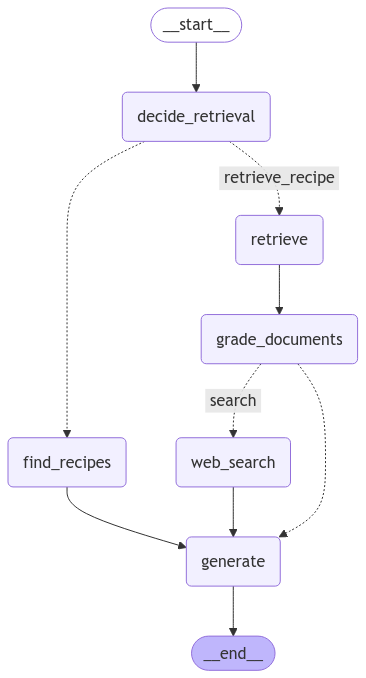

In [11]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("decide_retrieval", decide_retrieval)  # Decide retrieval
workflow.add_node("find_recipes", find_recipes)  # Suggest recipes
workflow.add_node("retrieve", retrieve)  # retrieve recipe
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("decide_retrieval")
workflow.add_conditional_edges(
    "decide_retrieval",
    lambda state: state["decision"],
    {"retrieve_recipe": "retrieve", "find_recipes": "find_recipes"},
)
workflow.add_edge("find_recipes", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"search": "web_search", "generate": "generate"},
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))



---



---



## **Test the Assistant**

1.   Retrieve relevant information from the available documents


In [12]:
example = {
    "input": "How to prepare a chocolate cake ?"
}

response = predict_custom_agent_answer(example)
print(response["response"])

**Ultimate Chocolate Cake Recipe**

**Ingredients:**

• 3 oz. unsweetened chocolate
• 1 c. unsalted butter
• 2 1/3 c. firmly packed light brown sugar
• 2 1/3 c. sifted cake flour
• 2/3 c. buttermilk
• 1 c. boiling water
• 1 tsp. vanilla
• 3 large eggs
• 2 tsp. baking soda
• 1 tsp. salt

**Steps:**

1. **Preheat the oven:**
	* Heat the oven to 350°.
2. **Prepare the cake pans:**
	* Brush cake pans with melted butter and dust with sifted flour, shaking out excess.
	* Chill the pans until needed.
3. **Melt the chocolate:**
	* Melt the chocolate in the top of a double boiler.
	* Allow the chocolate to cool.
4. **Cream the butter and sugar:**
	* Cream together butter and sugar.
5. **Add the eggs:**
	* Add eggs, one at a time, beating well.
6. **Add the melted chocolate:**
	* Mix in the melted, cooled chocolate.
7. **Combine the dry ingredients:**
	* Sift together flour, baking soda, and salt.
8. **Gradually add the dry ingredients:**
	* Add the dry ingredients to the chocolate mixture, alte

In [13]:
print(response['steps'])

['decide_retrieval', 'retrieve_documents', 'grade_document_retrieval', 'generate_answer']


2.   Conduct a web search to retrieve relevant documents



In [14]:
example = {
    "input": "I want a galette bretonne"
}

response = predict_custom_agent_answer(example)
print(response["response"])

**Galette Bretonne Recipe**

A traditional French dish, Galette Bretonne is a crispy buckwheat pancake filled with gooey Gruyère, roasted tomatoes, and a sunny side up egg. Here's a recipe to make this delightful breakfast or brunch dish:

**Ingredients:**

* 330 gr flour of buckwheat
* 10 gr salt
* Gruyère cheese
* Roasted tomatoes
* 1 egg
* Optional: ham, French Comté cheese

**Steps:**

1. **Prepare the Buckwheat Batter:** Mix together 330 gr flour of buckwheat and 10 gr salt.
2. **Form the Galettes:** Put a crepe on a large baking sheet, bubble side up.
3. **Add the Filling:** Scatter the center with some cheese (Gruyère or French Comté) and ham (optional). Crack in an egg.
4. **Fold the Galette:** Fold the crepe into a triangle or a square shape to enclose the filling.
5. **Serve:** Serve the galette hot, garnished with roasted tomatoes and a sprinkle of salt.

**Tips and Variations:**

* Use a French Comté cheese for a more authentic flavor.
* Add some ham or other savory ingredi

In [15]:
print(response['steps'])

['decide_retrieval', 'retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


3.   Suggest recipes based on provided ingredients

In [16]:
example = {
    "input": "I have pasta, meat sauce and cheese !"
}

response = predict_custom_agent_answer(example)
print(response["response"])

**Pasta Recipes using Meat Sauce and Cheese**

We've found three delicious pasta recipes that combine meat sauce and cheese. Here are the details:

**Recipe 1: 4 Cheese Pasta**

* **Ingredients:**
	+ 6 oz. penne or tube noodles
	+ 3/4 lb. ground beef
	+ 1 (14 oz.) can chunky pasta style tomatoes
	+ 1 c. sliced green onions
	+ 1 (3 oz.) pkg. cream cheese
	+ 1/2 c. shredded Swiss cheese
	+ 1/2 c. shredded Parmesan cheese
	+ 1/2 c. shredded cheddar cheese
* **Steps:**
	1. Cook pasta and drain.
	2. Brown meat and drain grease.
	3. Add tomatoes; cook, uncovered, until thickened.
	4. Stir in onions and cream cheese.
	5. Toss in remaining cheeses.
	6. Cook until cheeses melt. Serve with Italian bread.

**Recipe 2: Plenty for 20**

* **Ingredients:**
	+ 1 lb. chopped beef
	+ 1 lb. chopped pork
	+ 1 large can mushrooms
	+ 3 sliced stalks celery
	+ 1 (16 oz.) can stewed tomatoes
	+ 1 lb. box vermicelli
	+ 1 large pkg. Velveeta cheese
* **Steps:**
	1. Brown meat.
	2. Add celery and mushrooms.
	3.

In [17]:
print(response['steps'])

['decide_retrieval', 'find_recipes', 'generate_answer']
